In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## **Get various imports and helper functions**

The code in the following cells prepares imports and data

In [ ]:

# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

## **Get Data**

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## **Data Pre-Processing**

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2d6418d2e0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

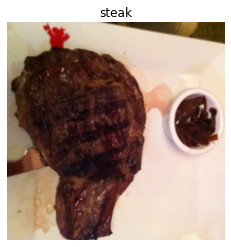

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## **Replicate the ViT architecture we created with in-built PyTorch transformer layers.**


1.   You'll want to look into replacing our TransformerEncoderBlock() class with torch.nn.TransformerEncoderLayer() (these contain the same layers as our custom blocks).
2.   You can stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder().
Need:



You can stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder().
Need:


*   PatchEmbedding (turn images into embedded patches)
*   Transformer Encoder layer (this is comprised of alternating MSA and MLP blocks)
*   Stack multiple transformer encoder layers on top of each other
*   
MLP head
*   
Put it all together to create ViT




In [ ]:

rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape


torch.Size([32, 3, 224, 224])

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [ ]:

patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


## 2. Transformer EnCoder Layer

In [ ]:
# Hyperparameters from Table 1 and Table 3 for ViT-Base
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:

from torchinfo import summary

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

In [ ]:

transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

# transformer_encoder

In [ ]:

# summary(model=transformer_encoder,
#         input_size=patch_embedding_output.shape)


## **5. Creating VIT**

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x


In [ ]:

demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape)

# Create ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[ 0.4400,  0.2145, -0.8793]], grad_fn=<AddmmBackward0>)

In [ ]:
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [ ]:

len(class_names)

3

In [ ]:
embedding_dim=768
class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                       requires_grad=True)
class_token.requires_grad


True

In [ ]:
batch_size = 32
print(class_token.shape)
class_token.expand(batch_size, -1, -1).shape # "-1" means to infer the dimension

torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [ ]:

patch_size = 16
img_size = 224
num_patches = (img_size*img_size) // patch_size**2
pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

## **Turn the custom ViT architecture we created into a Python script, for example, vit.py.**

In [ ]:
%%writefile vit.py
import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Writing vit.py


In [ ]:

!python vit.py

In [ ]:

from vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Train a pretrained ViT feature extractor model (like the one we made in 08. PyTorch Paper Replicating section 10) on 20% of the pizza, steak and sushi data like the dataset we used in 07. PyTorch Experiment Tracking section 7.3

In [ ]:

set_seeds()

In [ ]:

# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the preatrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:

# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                           test_dir=test_dir, # use 10% data for testing
                                                                                           transform=vit_transforms,
                                                                                           batch_size=32)

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader)

(8, 15, 3)

In [ ]:

# Train a pretrained ViT feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3436 | train_acc: 0.9083 | test_loss: 0.1891 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.1281 | train_acc: 0.9646 | test_loss: 0.2246 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.0928 | train_acc: 0.9771 | test_loss: 0.1937 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.0633 | train_acc: 0.9792 | test_loss: 0.1870 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.0535 | train_acc: 0.9854 | test_loss: 0.1901 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.0572 | train_acc: 0.9917 | test_loss: 0.1857 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0409 | train_acc: 0.9938 | test_loss: 0.1958 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.0333 | train_acc: 1.0000 | test_loss: 0.2146 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0400 | train_acc: 0.9979 | test_loss: 0.2143 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0243 | train_acc: 1.0000 | test_loss: 0.2043 | test_acc: 0.9280


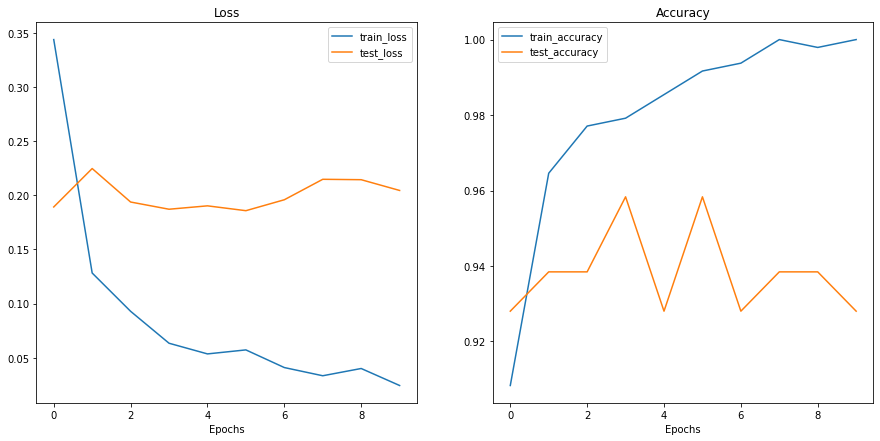

In [ ]:
# Examine results
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the preatrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit_swag,
        input_size=(1, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [ ]:
# Check out transforms for pretrained ViT with SWAG weights
vit_transforms_swag = vit_weights_swag.transforms() # get transforms from vit_weights_swag
vit_transforms_swag


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:

# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms_swag,
                                                                                          batch_size=32)

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [ ]:

# Train a pretrained ViT feature extractor with SWAG weights
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:


from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_swag_results)

In [ ]:
# Get all test data paths
from tqdm import tqdm
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=pretrained_vit_swag,
                                 transform=vit_transforms_swag,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

100%|██████████| 75/75 [03:04<00:00,  2.45s/it]


[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9582934975624084,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8886326551437378,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8648464679718018,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8625379800796509,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8377705216407776,
  'pred_class': 'steak',
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
70,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.536348,steak,False
54,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,0.994473,pizza,True
73,data/pizza_steak_sushi/test/pizza/714866.jpg,pizza,0.994156,pizza,True
60,data/pizza_steak_sushi/test/pizza/3475871.jpg,pizza,0.994150,pizza,True
50,data/pizza_steak_sushi/test/pizza/2111981.jpg,pizza,0.993759,pizza,True


In [ ]:
# How many samples from the test dataset did our model get correct?
test_pred_df.correct.value_counts()

True     74
False     1
Name: correct, dtype: int64

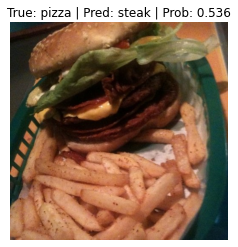

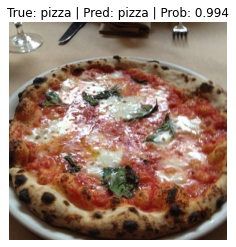

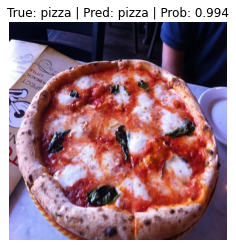

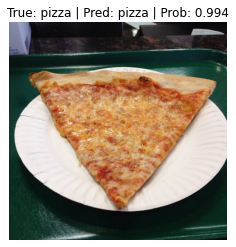

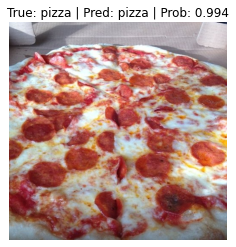

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);


**## IMPROVEMENT**

**ImageNet-22k pretraining (more data)** - Train a model on a large corpus of images (14 million in the case of ImageNet-22k) with 22,000 classes so it can learn a good underlying representation of images that can be applied to other problems.

**Learning rate warmup** - start with a small learning rate (almost 0) and warm it up to a desired value (e.g. 1e-3) to prevent a model's loss from exploding during the start of training.
Learning rate decay - slowly lower learning rate overtime so a model's loss doesn't explode when it's close to convergence (like reaching for a coin at the back of a couch, the closer you get to the coin, the small steps you take).

**Gradient clipping** - reduce a model's gradients by a certain amount to prevent them from getting too large and causes the loss to explode.

All of the above are ways to prevent overfitting (regularization) and in the case of ImageNet-22k pretraining, it also helps to prevent underfitting (apply learned patterns from another dataset to your own for better performance).